# Covariance matrix
Generalization of variance to multivariate cases.

Links

* [DataSciencePlus](https://datascienceplus.com/understanding-the-covariance-matrix/) plots changes in the covariance matrix, rotates the data by matrix multiply, computes the eigenvalues, and uses the inverse for "whitening".

## from Variance to Covariance
Compute variance over n samples like this:    
var(X) = $\sigma^2(X) = (1/n)\sum_1^n[(\mu_{x}-x)^2]$  

Rewrite variance as covariance of X with itself:    
cov(X,X) = $\sigma(X,X) = (1/n)\sum_1^n[(\mu_{x}-x)(\mu_{x}-x)^T]$  

Now substitute Y for X:     
cov(X,Y) = $\sigma(X,Y) = (1/n)\sum_1^n[(\mu_{x}-x)(\mu_{y}-y)^T]$  

Covariance matrix:  
This is a symmetric matrix.   
Diagonal elements = Variance(X).   
Off-diagonals = Covariance(X,Y).   

    Matrix    Circle  WideElipse  TallElipse  DiagonalElipse
    XX  XY    1 0     2 0         1 0         1 2
    YX  YY    0 1     0 1         0 2         2 1



## Correlation vs Covariance 
There are similarities and differences.    
Correlation varies from -1 to +1.  
+ Positive cor gives a bottom-left to top-right diagonal.  
+ Negative cor gives a bottom-right to top-left diagonal.  
+ Zero cor implies independence.  

Covariance varies from can be anything.  
+ Positive off-diagonal cov gives a bottom-left to top-right diagonal.  
+ Negative off-diagonal cov gives a bottom-right to top-left diagonal.  
+ Zero covariance means statistical independence.  

Imagine data tight on the positive diagonal.  
The XY correlations are close to 1 because large X correlates to large Y.  
But the XY covariances are close to variances.  

In [1]:
import numpy as np
from scipy.stats import multivariate_normal
from numpy.random import normal  # random number generators
import matplotlib.pyplot as plt
import math

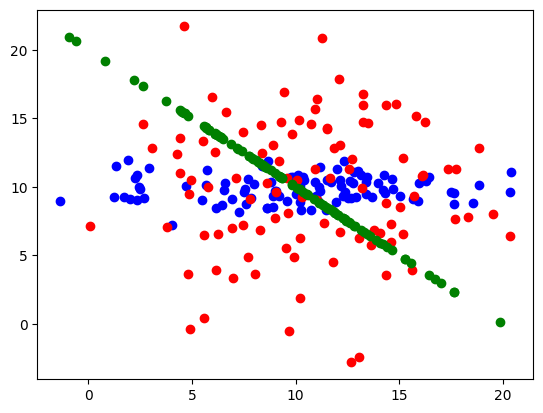

In [2]:
means = np.array([10,10])
N = 100
covB = np.array([[20, 0], [0, 1]]) # blue : high X variance
covR = np.array([[20, 0], [0, 20]]) # red : high X and Y variance, no covariance
covG = np.array([[20, -20], [-20, 20]])  # green : covariance close to variance
dataB = multivariate_normal.rvs(means, covB, N)
dataR = multivariate_normal.rvs(means, covR, N)
dataG = multivariate_normal.rvs(means, covG, N)
plt.scatter(dataB[:,0],dataB[:,1],color='blue')
plt.scatter(dataR[:,0],dataR[:,1],color='red')
plt.scatter(dataG[:,0],dataG[:,1],color='green')
plt.show()

### Using numpy

Note on numpy peculiarity noted on [StackOverflow](https://stackoverflow.com/questions/17428621/python-differentiating-between-row-and-column-vectors)   
Although np.transpose(2x3matrix) returns a (3x2matrix),   
and np.dot(np.transpose) handles the transpose correctly,   
numpy transposes matrices for you as needed for calculations,   
so you can usually get away without coding the transpose.   
In fact, numpy vectors are not inherently row-vectors or column vectors.   
So np.transpose(vector) is a no-op.   

In [3]:
# Demonstrate that numpy does the transpose for you
mylist = [1,2,3]
myvector = np.array(mylist)
print("original=",myvector,"transpose=",np.transpose(myvector),
      "dot product:",myvector.dot(np.transpose(myvector)))
print("Same result without the transpose:",myvector.dot(myvector))

original= [1 2 3] transpose= [1 2 3] dot product: 14
Same result without the transpose: 14


### Covariance, implemented from scratch 
(well, using numpy for matrix multiplication)  
We'll handle the easiest case: using 2 variables and 2x2 covariance matrix.  
The computation requires matrix inverse and matrix determinant.  
The computation gets harder at higher dimensions.  
In fact, the compute can be impossible (when matrix not positive semidefinite).  
So, we'll just implement the simple 2x2 case.  

In [4]:
def roll_matrix(a,b,c,d):  # return 2x2 array
    M = np.zeros((2,2))
    M[0,0] = a
    M[0,1] = b
    M[1,0] = c
    M[1,1] = d
    return M
def unroll_matrix(M):    # return matrix as tuple
    a = M[0,0]
    b = M[0,1]
    c = M[1,0]
    d = M[1,1]
    return a,b,c,d
def determinant(M):      # determinant of 2x2 matrix
    a,b,c,d = unroll_matrix(M)
    det = a*d - b*c
    return det
def inverse(M):          # inverse of 2x2 matrix (may not exist)
    det = determinant(M)
    if det==0:
        return None
    denominator = 1 / det
    tup = unroll_matrix(M)
    a,b,c,d = tuple(t/denominator for t in tup) 
    IM = roll_matrix(d,-b,-c,a)
    return IM

mahalanobis_distance = $\sqrt{(X-\mu)\Sigma^{-1}(X-\mu)^{T}}$

In [5]:
# Use numpy for dot product = inner product = sum ai*bi.
def mahalanobis_distance_squared(X,means,cov):   # distance X from distribution, used by Gauss
    inv = inverse(cov) # inverse: 2x2 matrix
    dev = np.subtract(X,means) # X - mu elementwise vector subtraction
    prod = dev.dot(inv).dot(dev)   # (deviation)(inverse Sigma)(deviation)
    # actual distance is the sqrt of this
    return prod
def multivariate_gaussian_prob(X,means,cov):
    """Shapes X:1x2, means:1x2, covariance:2x2"""
    dimensionality = 2  # assumed
    exponent = dimensionality/2  # 1D data uses sqrt, 2D data uses no exponent
    det = determinant(cov) # determinant: scalar
    constant = 1/(math.sqrt(det)*(2*math.pi)**exponent) # scalar. At D=2, exp=1
    mds = mahalanobis_distance_squared(X,means,cov)
    exponent = (-1/2)*mds
    prob = constant * math.exp(exponent)
    return prob

### Test our results against scipy

In [6]:
from scipy.stats import multivariate_normal
means = np.asarray( (5,3) )
cov = roll_matrix(10,3,3,1)
X = np.asarray( (5,3) )   
lib=multivariate_normal(mean=[5,3], cov=[[10,3],[3,1]])
print("Point at dead center")
print("Our value:",multivariate_gaussian_prob(X,means,cov))
print("Lib value:",lib.pdf(X))

Point at dead center
Our value: 0.15915494309189535
Lib value: 0.1591549430918954


In [7]:
X = np.asarray( (6,3) ) 
print("Point at Y center, off-center X")
print("High variance of X makes this pretty likely")
print("Our value:",multivariate_gaussian_prob(X,means,cov))
print("Lib value:",lib.pdf(X))

Point at Y center, off-center X
High variance of X makes this pretty likely
Our value: 0.09653235263005391
Lib value: 0.09653235263005393


In [8]:
X = np.asarray( (5,4) )  
print("Point at Y off-center, center X")
print("Low variance of Y makes this pretty unlikely")
print("Our value:",multivariate_gaussian_prob(X,means,cov))
print("Lib value:",lib.pdf(X))

Point at Y off-center, center X
Low variance of Y makes this pretty unlikely
Our value: 0.0010723775711956546
Lib value: 0.0010723775711956479
